In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("train.csv")
print(train.shape)
train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
test = pd.read_csv("test.csv")
print(test.shape)
test.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# put label column from train to test and delete the label column from train
y_train = train["label"]
x_train = train.drop(labels= ["label"], axis = 1)

In [14]:
y_train.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

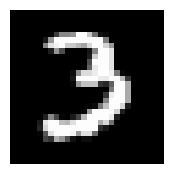

In [26]:
plt.figure(figsize=(2,2))
img = x_train.iloc[9].values
img = img.reshape((28, 28))
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

* Normalization
    * As the pixel values range from 0 to 256, apart from 0 the range is 255. So dividing all the values by 255 will convert it to range from 0 to 1.
    * If we normalize the data, CNN works faster.
* Reshape
    * Keras need an extra dimension in the end which correspond to channels. Our images are gray scaled so it use only one channel.
* Label Encoding
    * Encode labels to one hot vectors

In [27]:
# Normalize the data
x_train = x_train / 255.0
test = test / 255.0
print("X train shape : ", x_train.shape)
print("Test shape : ", test.shape)

X train shape :  (42000, 784)
Test shape :  (28000, 784)


In [28]:
# Reshape
x_train = x_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)
print("x_train shape : ", x_train.shape)
print("test shape : ", test.shape)

x_train shape :  (42000, 28, 28, 1)
test shape :  (28000, 28, 28, 1)


In [29]:
# Label Encoding
from keras.utils.np_utils import to_categorical  # convert to one hot encoding
y_train = to_categorical(y_train, num_classes = 10)

In [30]:
# Train Test split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.15, random_state = 15)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(35700, 28, 28, 1) (6300, 28, 28, 1) (35700, 10) (6300, 10)


In [82]:
# 
from sklearn.metrics import confusion_matrix
import itertools

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))


In [83]:
# Define optimizer
optimizer = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)

# compile model
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

In [88]:
# set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor="val_accuracy",
                                            patience=3,
                                            verbose=1,
                                            factor = 0.5,
                                            min_lr = 0.00001)

## Data Augmentation

* to aviod overfitting problem, we need to expand our dataset.
* Alter the training data with small transformations to reproduce the variations of digit.

In [89]:
# Data Augmentation

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=10,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 5%
        width_shift_range=0.1,  # randomly shift images horizontally 5%
        height_shift_range=0.1,  # randomly shift images vertically 5%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [90]:
epochs = 30
batch_size = 100

In [91]:
# fit model
history  = model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size),
                                epochs = epochs, validation_data = (x_test, y_test),
                                steps_per_epoch=x_train.shape[0] // batch_size,
                                callbacks=[learning_rate_reduction])

Epoch 1/30
357/357 [==============================] - 141s 394ms/step - loss: 0.1737 - accuracy: 0.9499 - val_loss: 0.0511 - val_accuracy: 0.9849 - lr: 0.0010
Epoch 2/30
357/357 [==============================] - 130s 365ms/step - loss: 0.1307 - accuracy: 0.9613 - val_loss: 0.0388 - val_accuracy: 0.9890 - lr: 0.0010
Epoch 3/30
357/357 [==============================] - 128s 358ms/step - loss: 0.1129 - accuracy: 0.9662 - val_loss: 0.0474 - val_accuracy: 0.9867 - lr: 0.0010
Epoch 4/30
357/357 [==============================] - 131s 368ms/step - loss: 0.1021 - accuracy: 0.9715 - val_loss: 0.0342 - val_accuracy: 0.9898 - lr: 0.0010
Epoch 5/30
357/357 [==============================] - 125s 350ms/step - loss: 0.0881 - accuracy: 0.9761 - val_loss: 0.0472 - val_accuracy: 0.9871 - lr: 0.0010
Epoch 6/30
357/357 [==============================] - 125s 349ms/step - loss: 0.0816 - accuracy: 0.9759 - val_loss: 0.0491 - val_accuracy: 0.9879 - lr: 0.0010
Epoch 7/30
357/357 [==========================

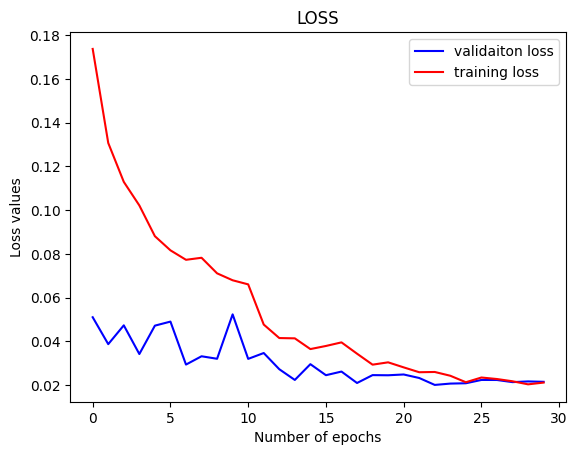

In [92]:
plt.plot(history.history["val_loss"], color = 'b', label = "validaiton loss")
plt.plot(history.history["loss"], color = "r", label = "training loss")
plt.title("LOSS")
plt.xlabel("Number of epochs")
plt.ylabel("Loss values")
plt.legend()
plt.show()

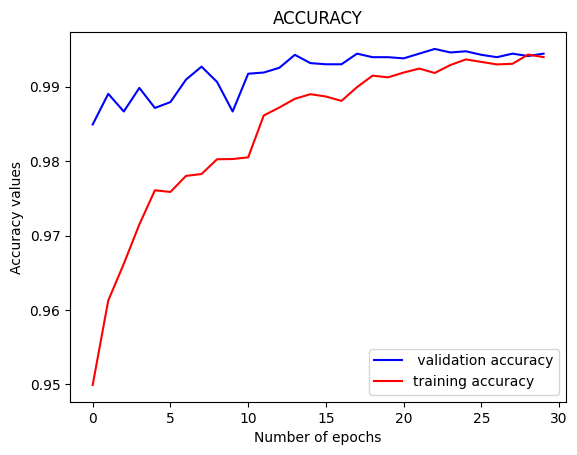

In [93]:
plt.plot(history.history["val_accuracy"], color = 'b', label = " validation accuracy")
plt.plot(history.history["accuracy"], color = "r", label = "training accuracy")
plt.title("ACCURACY")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy values")
plt.legend()
plt.show()

197/197 [==============================] - 5s 26ms/step


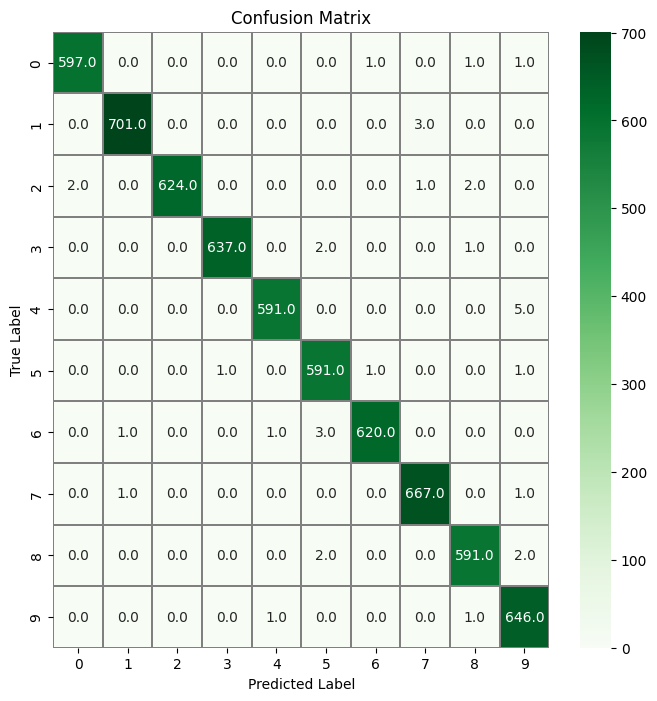

In [94]:
# confusion matrix
import seaborn as sns

y_pred = model.predict(x_test) # predict values from validation data
y_pred_classes = np.argmax(y_pred, axis = 1) # convert prediction classes to one hot vector
y_true = np.argmax(y_test, axis = 1) # convert validation observations to one hot vectors

confusion_m = confusion_matrix(y_true, y_pred_classes)

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_m, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
